<a href="https://colab.research.google.com/github/arauber-psychologistcoder/ari-psycoder/blob/main/rede_neural_zero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [ ]:
transform = transforms.ToTensor() #definindo a conversão de imagem para tensor

trainset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform) #carrega a parte de treino de dataset
trainloader = torch.utils.data.DataLoader (trainset, batch_size=64, shuffle=True) #cria um buffer para pegar os dados por partes

valset = datasets.MNIST('./MNIST_data/', download=True, train=False, transform=transform) #carrega a parte de validação do dataset
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True) #cria um buffer para pegar os dados por partes

100%|██████████| 9.91M/9.91M [00:00<00:00, 46.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.11MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.69MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.71MB/s]


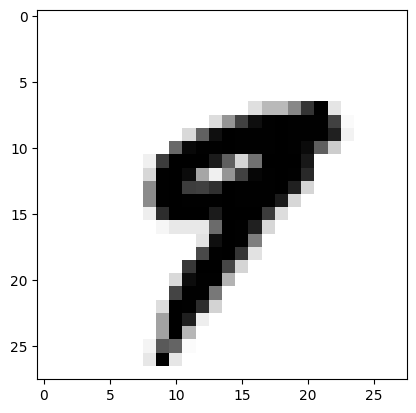

In [ ]:
dataiter = iter(trainloader)
imagens, etiquetas = next(dataiter)
plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r')

In [ ]:
print(imagens[0].shape) #para verificar as dimensões do tensor de cada imagem
print(etiquetas[0].shape) #para verificar as dimensões do tensor de cada etiqueta


torch.Size([1, 28, 28])
torch.Size([])


In [ ]:
class Modelo(nn.Module):
  def _init_(self):
    super(Modelo, self) ._init_()
    self.linear1 = nn.Linear(28*28, 128) #camada de entrada, 784 neurônios que se ligam a 128
    self.linear2 = nn.Linear(128, 64) #camada interna 1, 128 neurônios que se ligam a 64
    self.linear3 = nn.linear(64, 10) #camada interna 2,64 neurônios que se ligam a 10
    #para cada camada de saída não é necessário definir nada pois só precisamos pegar o output da camada interna 2

  def forward(self, X):
    X = F.relu(self.linear1(X)) #função de ativação da camadade entrada para a camada interna 1
    X = F.relu(self.linear2(X)) #função de ativação da camada interna 1 para a camada interna 2
    X = self.linear3(X) #função de ativaçãoda camada interna 2 para a camada de saída, nesse caso f(x) = x
    return F.log_softmax (X, dim=1) #dados utilizados para calcular a perda

In [ ]:
from time import time
import torch.optim as optim
import torch.nn as nn

def treino(modelo, trainloader, device):

  otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5) #define a política de atualizaçãodo pesos e bias
  inicio = time() #timer para sabermos quanto tempo levou o treinamento

  criterio = nn.NLLLoss() #definindo o critério para calcular a perda
  EPOCHS = 10 #numero de epochs que o algoritimo rodará, o ideal é ao menos 100
  modelo.train() #ativando o modo de treinamento do modelo

  for epoch in range(EPOCHS):
    perda_acumulada = 0 #inicialização da perda acumulada em questão

    for imagens, etiquetas in trainloader:

      imagens = imagens.view(imagens.shape[0], -1).to(device) #convertendo as imagens para "vetores" de 28*28 casas para..
      etiquetas = etiquetas.to(device)

      otimizador.zero_grad() #zerando os gradientes por conta do ciclo anterior

      output = modelo(imagens) #colocando os dados do modelo
      perda_instantanea = criterio(output, etiquetas) #calculando a perda da epoch em questão

      perda_instantanea.backward() #back propagation a partir da perda

      otimizador.step() #atualizando os pesos e bias

      perda_acumulada += perda_instantanea.item() #atualização de perda acumulada

    else:
      print('Epoch {} - Perda resultante: {}'.format(
          epoch+1, perda_acumulada/len(trainloader))
      )

  print('\nTempo de treino (em minutos) =', (time()- inicio)/60)

In [3]:
def validacao(modelo, valloader, device):
    conta_corretas, conta_todas = 0, 0

    # desativar o autograd para acelerar a validação, Grafos computacionais dinâmicos tem custo alto de processamento
    with torch.no_grad():
        for imagens, etiquetas in valloader:
            for i in range(len(etiquetas)):
                img = imagens[i].view(1, 784)

                logps = modelo(img.to(device))  # output do modelo em escala algotitmica

                ps = torch.exp(logps)  # converte output para escala normal (lembrando que é um tensor)
                probab = list(ps.cpu().numpy()[0])

                etiqueta_pred = probab.index(max(probab))  # converte o tensor em um número, no caso, o número é o modelo prévio
                etiqueta_certa = etiquetas[i].item()       # valor correto da etiqueta

                if etiqueta_certa == etiqueta_pred:  # compara a previsão com valor correto
                    conta_corretas += 1

                conta_todas += 1

    print("Total de imagens testadas =", conta_todas)
    print("\nPrecisão do modelo = {}%".format(conta_corretas * 100 / conta_todas))

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Modelo(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(784, 128)
        self.linear2 = nn.Linear(128, 64)
        self.linear3 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.log_softmax(self.linear3(x), dim=1)
        return x